In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import pyqg
from pyqg import diagnostic_tools as tools

colors = [(0.33725, 0.70588, 0.91373),
          (0.90196, 0.62353, 0.00000),
          (0.00000, 0.61961, 0.45098),
          (0.94118, 0.89412, 0.25882),
          (0.00000, 0.44706, 0.69804),
          (0.83529, 0.36863, 0.00000),
          (0.80000, 0.47451, 0.65490)]

In [2]:
def save_with_snapshots(m, tsnapint):
    
    model_output = m_bt.to_dataset()
    
    for _ in m.run_with_snapshots(tsnapstart = 0., tsnapint = tsnapint):
        
        model_output = xr.concat([model_output, m_bt.to_dataset()], dim = 'time')
        
    return model_output

# Tests with my edits for *linear* topographic slopes

## Test three layer QG model with my edits to the kernel and layered_model (test without linear or rough topography)

I use the example in the pyqg docs, with a few edits.

In [55]:
# Grid, dimensions
L =  1000.e3     # length scale of box    [m]
Ld = 15.e3       # deformation scale      [m]
kd = 1./Ld       # deformation wavenumber [m^-1]
nx = 64          # number of grid points in x
ny = nx          # number of grid points in y
nz = 3           # number of levels

# Background shear, stratification and topography
U1 = 0.05          # layer 1 zonal velocity [m/s]
U2 = 0.025         # layer 2
U3 = 0.00          # layer 3

rho1 = 1025.
rho2 = 1025.275
rho3 = 1025.640

H1 = 500.        # layer 1 thickness  [m]
H2 = 1750.       # layer 2
H3 = 1750.       # layer 3

hy = 0. # 1e-5        # Gradient of topographic slope in y
hx = 0. # 1e-5        # Gradient of topographic slope in x

def zero_mean_bump(h, n, L, xx, yy):
    
    return h * np.sin(2*n * np.pi / L * xx) * np.sin(2*n * np.pi / L * yy)

def non_zero_mean_bump(h, n, L, xx, yy):
    
    c = 1.
    
    return h * (np.cos(2*n * np.pi / L * c * xx) + np.sin(2*n * np.pi / L * c * yy))

x = np.linspace(0., L, int(nx))
y = np.linspace(0., L, int(nx))
xx, yy = np.meshgrid(x, y)

htop = 0 * zero_mean_bump(1, 3, L, xx, yy)

# Planetary stuff
f0 = 1e-4
omega = 7.2921159e-5
a = 6.371e6
lat = np.arcsin(f0 / (2 * omega))
beta = 2 * omega / a * np.cos(lat)
rek = 1e-7       # linear bottom drag coeff.  [s^-1]

# Time
# dt = 10800 / 60                # time step [s].
# tmax = 60 * 60 * 24 * 5        # model run time [s]
# tmax = dt * 1000

Ti = Ld/(abs(U1))  # estimate of most unstable e-folding time scale [s]
dt = Ti/400.       # time-step [s]
tmax = dt * 1000    # simulation time [s]


m = pyqg.LayeredModel(nx = nx, ny = ny, nz = nz, L = L, rd = Ld, 
                      U = [U1,U2,U3], V = [0.,0.,0.],
                      rho = [rho1, rho2, rho3],
                      H = [H1, H2, H3], hx = hx, hy = hy, htop = htop,
                      f = f0, beta = beta, rek = rek,
                      dt = dt, tmax = tmax, twrite = 100)

m.run()

INFO:  Logger initialized
INFO: Step: 100, Time: 7.50e+04, KE: 3.34e-07, CFL: 0.002
INFO: Step: 200, Time: 1.50e+05, KE: 3.31e-07, CFL: 0.002
INFO: Step: 300, Time: 2.25e+05, KE: 3.29e-07, CFL: 0.002
INFO: Step: 400, Time: 3.00e+05, KE: 3.28e-07, CFL: 0.002
INFO: Step: 500, Time: 3.75e+05, KE: 3.27e-07, CFL: 0.002
INFO: Step: 600, Time: 4.50e+05, KE: 3.26e-07, CFL: 0.002
INFO: Step: 700, Time: 5.25e+05, KE: 3.25e-07, CFL: 0.002
INFO: Step: 800, Time: 6.00e+05, KE: 3.25e-07, CFL: 0.002
INFO: Step: 900, Time: 6.75e+05, KE: 3.25e-07, CFL: 0.002
INFO: Step: 1000, Time: 7.50e+05, KE: 3.25e-07, CFL: 0.002


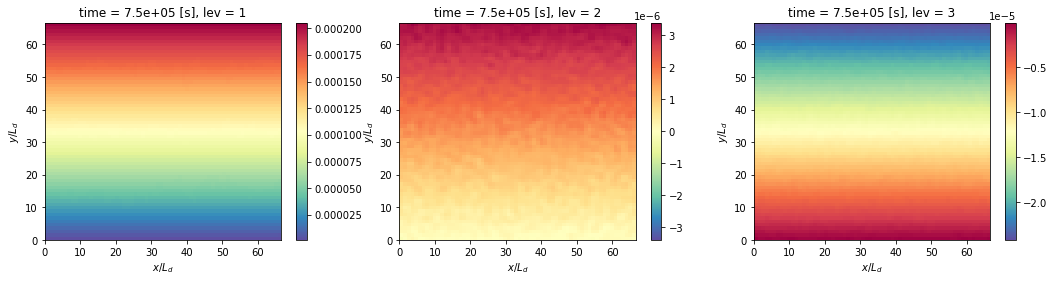

In [56]:
ds = m.to_dataset()
ds

PV = ds.q + ds.Qy * ds.y

for i in range(3):
    PV.isel(lev=i) == PV.isel(lev=i) + m.Qx[i] * ds.x
    
PV['x'] = ds.x/ds.attrs['pyqg:rd']; PV.x.attrs = {'long_name': r'$x/L_d$'}
PV['y'] = ds.y/ds.attrs['pyqg:rd']; PV.y.attrs = {'long_name': r'$y/L_d$'}


plt.figure(figsize=(18,4))

plt.subplot(131)
PV.sel(lev=1).plot(cmap='Spectral_r')

plt.subplot(132)
PV.sel(lev=2).plot(cmap='Spectral_r')

plt.subplot(133)
PV.sel(lev=3).plot(cmap='Spectral_r')

Good.

## Test three layer QG model with my edits to the kernel and layered_model (test with linear topography but no roughness)

Same parameters as experiment run above, except now with linear slopes in x and y

In [118]:
# Grid, dimensions
L =  1000.e3     # length scale of box    [m]
Ld = 15.e3       # deformation scale      [m]
kd = 1./Ld       # deformation wavenumber [m^-1]
nx = 64          # number of grid points in x
ny = nx          # number of grid points in y
nz = 3           # number of levels

# Background shear, stratification and topography
U1 = 0.05          # layer 1 zonal velocity [m/s]
U2 = 0.025         # layer 2
U3 = 0.00          # layer 3

rho1 = 1025.
rho2 = 1025.275
rho3 = 1025.640

H1 = 500.        # layer 1 thickness  [m]
H2 = 1750.       # layer 2
H3 = 1750.       # layer 3

hy = 1e-5        # Gradient of topographic slope in y
hx = 1e-5        # Gradient of topographic slope in x

def zero_mean_bump(h, n, L, xx, yy):
    
    return h * np.sin(2*n * np.pi / L * xx) * np.sin(2*n * np.pi / L * yy)

def non_zero_mean_bump(h, n, L, xx, yy):
    
    c = 1.
    
    return h * (np.cos(2*n * np.pi / L * c * xx) + np.sin(2*n * np.pi / L * c * yy))

x = np.linspace(0., L, int(nx))
y = np.linspace(0., L, int(nx))
xx, yy = np.meshgrid(x, y)

htop = 0 * zero_mean_bump(1, 3, L, xx, yy)

# Planetary stuff
f0 = 1e-4
omega = 7.2921159e-5
a = 6.371e6
lat = np.arcsin(f0 / (2 * omega))
beta = 2 * omega / a * np.cos(lat)
rek = 1e-7       # linear bottom drag coeff.  [s^-1]

# Time
# dt = 10800 / 60                # time step [s].
# tmax = 60 * 60 * 24 * 5        # model run time [s]
# tmax = dt * 1000

Ti = Ld/(abs(U1))  # estimate of most unstable e-folding time scale [s]
dt = Ti/400.       # time-step [s]
tmax = dt * 1000    # simulation time [s]


m = pyqg.LayeredModel(nx = nx, ny = ny, nz = nz, L = L, rd = Ld, 
                      U = [U1,U2,U3], V = [0.,0.,0.],
                      rho = [rho1, rho2, rho3],
                      H = [H1, H2, H3], hx = hx, hy = hy, htop = htop,
                      f = f0, beta = beta, rek = rek,
                      dt = dt, tmax = tmax, twrite = 100)

m.run()

INFO:  Logger initialized
INFO: Step: 100, Time: 7.50e+04, KE: 3.53e-07, CFL: 0.002
INFO: Step: 200, Time: 1.50e+05, KE: 3.50e-07, CFL: 0.002
INFO: Step: 300, Time: 2.25e+05, KE: 3.48e-07, CFL: 0.002
INFO: Step: 400, Time: 3.00e+05, KE: 3.46e-07, CFL: 0.002
INFO: Step: 500, Time: 3.75e+05, KE: 3.44e-07, CFL: 0.002
INFO: Step: 600, Time: 4.50e+05, KE: 3.43e-07, CFL: 0.002
INFO: Step: 700, Time: 5.25e+05, KE: 3.42e-07, CFL: 0.002
INFO: Step: 800, Time: 6.00e+05, KE: 3.41e-07, CFL: 0.002
INFO: Step: 900, Time: 6.75e+05, KE: 3.40e-07, CFL: 0.002
INFO: Step: 1000, Time: 7.50e+05, KE: 3.40e-07, CFL: 0.002


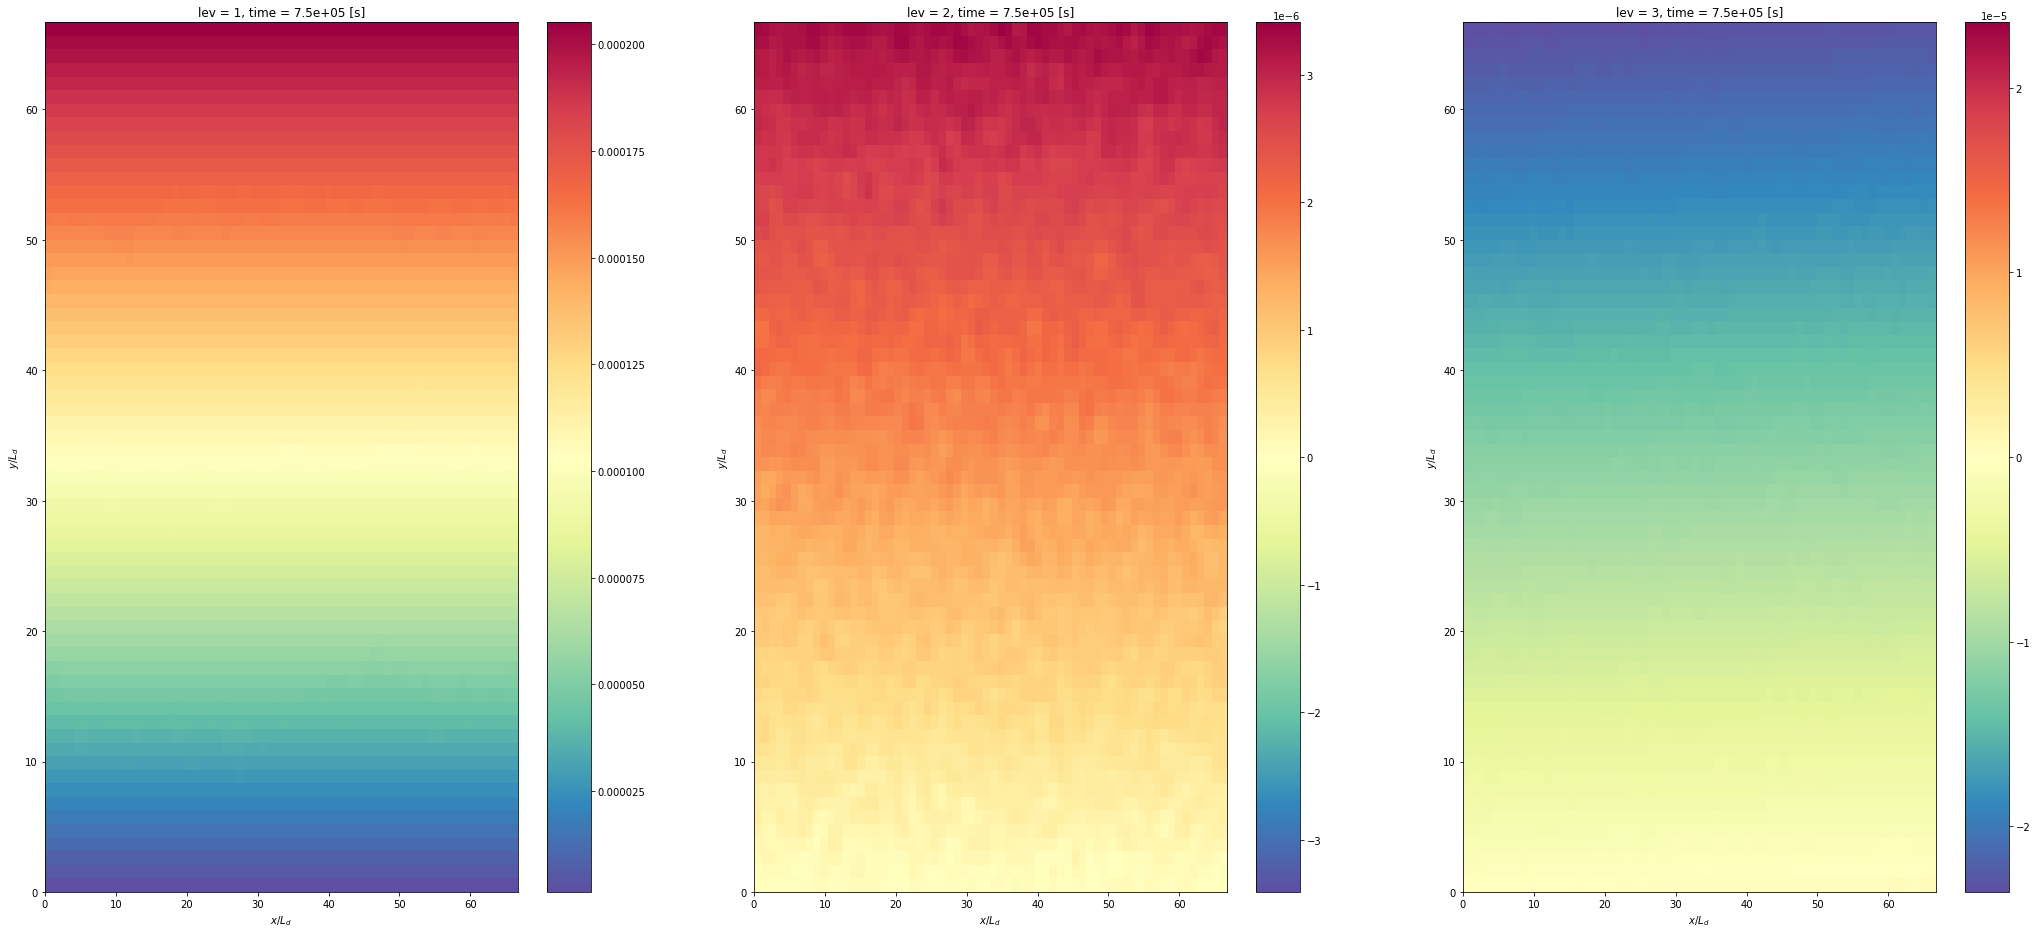

In [119]:
ds = m.to_dataset()
ds
Qx = xr.DataArray(m.Qx, dims='lev')

PV = ds.q + ds.Qy * ds.y + Qx * ds.x
    
PV['x'] = ds.x/ds.attrs['pyqg:rd']; PV.x.attrs = {'long_name': r'$x/L_d$'}
PV['y'] = ds.y/ds.attrs['pyqg:rd']; PV.y.attrs = {'long_name': r'$y/L_d$'}


plt.figure(figsize=(36,16))

plt.subplot(131)
PV.sel(lev=1).plot(cmap='Spectral_r')

plt.subplot(132)
PV.sel(lev=2).plot(cmap='Spectral_r')

plt.subplot(133)
PV.sel(lev=3).plot(cmap='Spectral_r')

Success again! Model ran fine. To be excected: an $h_y = 1e-5$ slope is equivalent to adding a $1e-12$ term to $\beta = 1e-11$, which we expect therefore to have a small effect.\\

Now let's try with some roughness in the topography!

## Test three layer QG model with my edits to the kernel and layered_model (test with linear and rough topography)

Same parameters as experiment run above, except now with linear slopes in x and y as well as roughness

In [137]:
# Grid, dimensions
L =  1000.e3     # length scale of box    [m]
Ld = 15.e3       # deformation scale      [m]
kd = 1./Ld       # deformation wavenumber [m^-1]
nx = 64          # number of grid points in x
ny = nx          # number of grid points in y
nz = 3           # number of levels

# Background shear, stratification and topography
U1 = 0.05          # layer 1 zonal velocity [m/s]
U2 = 0.025         # layer 2
U3 = 0.00          # layer 3

rho1 = 1025.
rho2 = 1025.275
rho3 = 1025.640

H1 = 500.        # layer 1 thickness  [m]
H2 = 1750.       # layer 2
H3 = 1750.       # layer 3

hy = 1e-5        # Gradient of topographic slope in y
hx = 1e-5        # Gradient of topographic slope in x

def zero_mean_bump(h, n, L, xx, yy):
    
    return h * np.sin(2*n * np.pi / L * xx) * np.sin(2*n * np.pi / L * yy)

def non_zero_mean_bump(h, n, L, xx, yy):
    
    c = 1.
    
    return h * (np.cos(2*n * np.pi / L * c * xx) + np.sin(2*n * np.pi / L * c * yy))

x = np.linspace(0., L, int(nx))
y = np.linspace(0., L, int(nx))
xx, yy = np.meshgrid(x, y)

htop = zero_mean_bump(1, 3, L, xx, yy)

# Planetary stuff
f0 = 1e-4
omega = 7.2921159e-5
a = 6.371e6
lat = np.arcsin(f0 / (2 * omega))
beta = 2 * omega / a * np.cos(lat)
rek = 1e-7       # linear bottom drag coeff.  [s^-1]

# Time
# dt = 10800 / 60                # time step [s].
# tmax = 60 * 60 * 24 * 5        # model run time [s]
# tmax = dt * 1000

Ti = Ld/(abs(U1))  # estimate of most unstable e-folding time scale [s]
dt = Ti/400.       # time-step [s]
tmax = dt * 100000    # simulation time [s]


m = pyqg.LayeredModel(nx = nx, ny = ny, nz = nz, L = L, rd = Ld, 
                      U = [U1,U2,U3], V = [0.,0.,0.],
                      rho = [rho1, rho2, rho3],
                      H = [H1, H2, H3], hx = hx, hy = hy, htop = 60000 * htop,
                      f = f0, beta = beta, rek = rek,
                      dt = dt, tmax = tmax, twrite = 10000)

m.run()

INFO:  Logger initialized
INFO: Step: 10000, Time: 7.50e+06, KE: 3.02e-07, CFL: 0.003
INFO: Step: 20000, Time: 1.50e+07, KE: 4.84e-07, CFL: 0.003
INFO: Step: 30000, Time: 2.25e+07, KE: 8.39e-07, CFL: 0.003
INFO: Step: 40000, Time: 3.00e+07, KE: 2.06e-06, CFL: 0.003
INFO: Step: 50000, Time: 3.75e+07, KE: 5.93e-06, CFL: 0.003
INFO: Step: 60000, Time: 4.50e+07, KE: 1.93e-05, CFL: 0.004
INFO: Step: 70000, Time: 5.25e+07, KE: 7.28e-05, CFL: 0.006
INFO: Step: 80000, Time: 6.00e+07, KE: 2.13e-04, CFL: 0.008
INFO: Step: 90000, Time: 6.75e+07, KE: 2.89e-04, CFL: 0.008
INFO: Step: 100000, Time: 7.50e+07, KE: 2.69e-04, CFL: 0.008
INFO: Step: 110000, Time: 8.25e+07, KE: 4.72e-04, CFL: 0.012
INFO: Step: 120000, Time: 9.00e+07, KE: 1.04e-03, CFL: 0.015
INFO: Step: 130000, Time: 9.75e+07, KE: 1.27e-03, CFL: 0.016
INFO: Step: 140000, Time: 1.05e+08, KE: 1.15e-03, CFL: 0.013
INFO: Step: 150000, Time: 1.12e+08, KE: 1.50e-03, CFL: 0.016
INFO: Step: 160000, Time: 1.20e+08, KE: 1.96e-03, CFL: 0.022
INFO: S

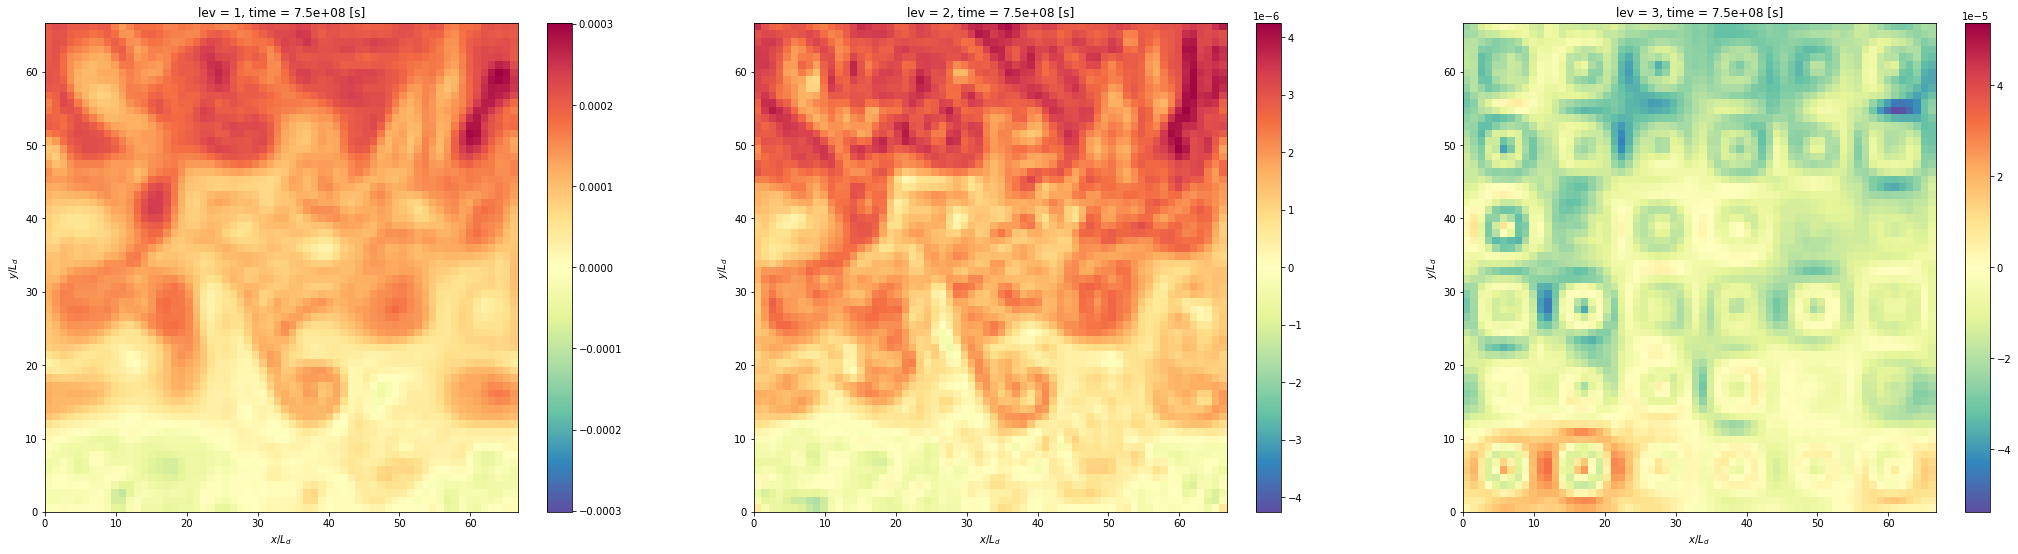

In [142]:
ds = m.to_dataset()
ds
Qx = xr.DataArray(m.Qx, dims='lev')

PV = ds.q + ds.Qy * ds.y + Qx * ds.x
    
PV['x'] = ds.x/ds.attrs['pyqg:rd']; PV.x.attrs = {'long_name': r'$x/L_d$'}
PV['y'] = ds.y/ds.attrs['pyqg:rd']; PV.y.attrs = {'long_name': r'$y/L_d$'}


plt.figure(figsize=(36,9))

plt.subplot(131)
PV.sel(lev=1).plot(cmap='Spectral_r')

plt.subplot(132)
PV.sel(lev=2).plot(cmap='Spectral_r')

plt.subplot(133)
PV.sel(lev=3).plot(cmap='Spectral_r')